
---
<big><big><big><big><big><big>Metody uczenia maszynowego</big></big></big></big></big></big>

---





---
<big><big><big><big><big>Maximum Likelihood Estimation MLE</big></big></big></big></big>

---



---

<id=tocheading><big><big><big><big>Spis treści</big></big></big></big>
<div id="toc"></div>

---

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

plt.style.use("fivethirtyeight")

from bokeh.io import gridplot, output_file, show
from bokeh.plotting import figure, output_notebook
from bkcharts import Scatter

In [3]:
output_notebook()
sns.set(font_scale=2.0)

Loading BokehJS ...

In [4]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from sklearn.datasets import load_boston, load_diabetes, load_linnerud
from sklearn.datasets import make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor, RANSACRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error

In [5]:
from astroML.datasets import fetch_imaging_sample
from sklearn.preprocessing import PolynomialFeatures
from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import BasisFunctionRegression

Image inclusion
<img src="../../mum_figures/" width="100%">

# Maximum likelihood
1. jeśli mamy model, to można oszacować prawdopodobieństwo (__likelihood__) obserwowania określonej wartości
  * niech dane $x_i$ będą losowane z rozkładu normalnego $\mathcal{N}(0,\sigma)$
  * wtedy szansa wylosowania $x$ jest dana przez $$p(x\mid\mu,\sigma)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)$$
2. __likelihood__ szansa obserwacji całego zbioru
$$L\equiv p(\{x_i\}\mid M(\theta))=\prod_{i=1}^{N}p(x_i\mid M(\theta))$$
  * $L$ to _prawdopodobieństwo obserwowania danych generowanych przez model_
  * __brak normalizacji__ $L$ nie jest poprawnie zdefiniowanym rozkładem 

3. niech
$$y=F(x)+\eta,\hskip{2em}\eta\sim\mathcal{N}(0,\sigma)$$
4. wtedy likelihood
$$\begin{align}
L\equiv p(Y\mid X,\theta,\sigma)&=\prod_i\mathcal{N}(y_i\mid \widehat{y}(x_i),\theta,\sigma)\\
&=\left(\frac{1}{\sqrt{2}\pi}\right)^N\prod_i\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
\end{align}$$
5. __log likelihood__ to $\ln L$
$$\begin{align}
\ln L =\ln p(Y\mid X,\theta,\sigma)
&=\sum_{i=1}^N\ln\mathcal{N} (y_i\mid\widehat{y}(x_i),\sigma)\\
&=-\frac{N}{2}\ln\sigma^2-\frac{N}{2}\ln(2\pi)-\frac{1}{2\sigma^2}\sum_{i=1}^N\left(y_i-\widehat{y}(x_k)\right)^2\\
&=const-\frac{1}{2\sigma^2}\sum_{i=1}^N\left(y_i-\widehat{y}(x_k)\right)^2
\end{align}$$
  * dla $\sigma=1$, stąd $$\ln L=-\frac{1}{2}\sum_{i=1}^N\left(y_i-\widehat{y}(x_k)\right)^2$$

## MLE dla danych z rozkładu normalnego
1. niech dane pochodzące z ro. normalnego
  * __IID__ dane są niezależnie i identycznie rozłożone
    * losowane niezależnie z tego samego rozkładu
    * częste założenie _często_ niespełnione
2. __likelihood__ $$p(X\mid \mu, \sigma)\prod_ip(x_i\mid\mu,\sigma)$$
3. __log-likelihood__ $$\ln p(X\mid\mu,\sigma)=-\frac{1}{2\sigma^2}\sum_i(x_i-\mu)^2-\frac{N}{2}\ln\sigma^2-\frac{N}{2}\ln\,2\pi$$
  * optymalizacja ze względu na __parametry modelu__
  $$\widehat{\mu}=\frac{1}{N}\sum_ix_i$$
  $$\widehat{\sigma}^2=\frac{1}{N}\sum_i(x_i-\widehat{\mu})^2$$
  * __niedoszacowanie__ $\widehat{\sigma}$ (problem _bias_)) stąd poprawka $${\tilde{\widehat{\sigma}}}^{\,2}=\frac{N}{N-1}\widehat{\sigma}^2$$
    * $N$ niezależnych $x_i$
    * $N-1$ niezależnych $(x1-\widehat{\mu}),\dots,(x_N,\widehat{\mu})$
    * poprawka Bessela
    * __overfitting__ wyniki są _zbyt dopasowane_ do danych
    * wzrost liczby przykładów ułatwia
      * modele wieloparametrowe dalej będą miały problemy

## Procedura maximum likelihood

1. __(log-) likelihood__  definicja $L\equiv p(D\mid M)$ dla modelu $M(\theta)$
2. __wyszukanie__ $\theta$ który maksymalizuje $L$
  * np. listy $\theta=(\theta_1, \theta_2,\dots,\theta_k)$
3. __przedziałów ufności__ dla elementów $\theta$
  * analitycznie jeśli możliwe
  * procedury częstotliwościowe: walidacja krzyżowa, jackknife, bootstrap
    * __ walidacja krzyżowa__
      1. podziel zbiór danych na $K$ części ($K=3,5,10$)
      2. powtórz  dla $k=1,\dots,K$
        1. $k$-ta jako część testowa, reszta ucząca
        2. zbuduj model
        3. $err_k$ = ewaluacja na części testowej
      3. $\overline{err}=\frac{1}{K}\sum_kerr_k$
    * __jackknife__ (nadoptymistyczny)
      1. powtórz dla $k=1,\dots,N$
        2. zbuduj model na $\{(X,Y)\}\setminus\{(x_k,y_k)\}$
        3. $err_k=\{(x_k,y_k)\}$
      3. $\overline{err}=\frac{1}{N}\sum_kerr_k$
    * __bootstrap__
      1. dla $k=1,\dots,B$ ($B=50,100$)
        2. wylosuj __ze zwracaniem__ zbiór uczący $D_k$ o liczności $N$
        3. zbuduj model $M$
        4. $err_k=\frac{1}{|x\not\in D_k|}\sum_{j: x_j\not\in D_k}l(y_j,\widehat{y}(x_j))$
      3. $\overline{err}=\frac{1}{B}\sum_kerr_k$ 
4. testy _hipotez_ dla wyciągnięcia wniosków

<img src="../mum_figures/linear_reg.png" width="70%">

### Problem regresji w MLE
1. __problem regresji__ dane 
$$\begin{align}&\{(x_i,y_i),i=1,\dots,N\},\hskip1.5em y_i\in\mathbb{R}\\
&y=F(x)+\epsilon,\hskip4.8em\epsilon\sim\mathcal{N}(0,\sigma^2)
\end{align}$$ dla nieznanej $F$
2. __problem__ dla modelu $\widehat{y}=\widehat{y}(x;\theta)$ znaleźć $\theta$ taki, że wartość prawdziwa (dane) 
  * ma rozkład normalny o średniej $\widehat{y}$ i ustalonej wariancji
3. __likelihood__ $$p(Y\mid X,\theta,\sigma)=\prod_i\mathcal{N}(y_i\mid \widehat{y}(x_i;\theta),\sigma^2)$$
  * __założenie__ dane $(x, y)$ są losowane _niezależnie_ z _tego samego_ rozkładu, wtedy $$p(Y\mid X,\theta,\sigma^2)=\prod_i p(y\mid \widehat{y}(x;\theta), \theta, \sigma^2)$$
    * __i.i.d.__ _independently and identically distributed_
4. __log likelihood__ $$\ln\,L\equiv\ln p(Y\mid\widehat{y}(X,\theta),\sigma)=-\frac{1}{2\sigma^2}\sum_i(y_i-\widehat{y}(x_i;\theta))^2-\frac{N}{2}\ln\sigma^2-\frac{N}{2}\ln\,2\pi$$
  * maksymalizacja log-likelihood jest równoważna minimalizacji sumy kwadratów błędów
  * __wariancja__ optymalizacja log-likelihood ze względu na $\sigma$
  $$\begin{align}
  \frac{\partial\ln L}{\partial\sigma}&=\partial\left[\frac{1}{2\sigma^2}\sum_i(y_i-\widehat{y}(x_i;\theta))^2-\frac{N}{2}\ln\sigma^2\right]\big/\partial\sigma\\
  &=\sigma^{-3}\sum_i(y_i-\widehat{y}(x_i;\theta))^2-\frac{N}{\sigma}=0\\
  \sigma^{-2}\sum_i(y_i-\widehat{y}(x_i;\theta))^2-N&=0\\
  \widehat{\sigma}^{\,2}&=\frac{1}{N}\sum_i(y_i-\widehat{y}(x_i;\theta))^2
  \end{align}$$
5. __maksymalizacja__ likelihood da $\theta$ i $\widehat\sigma$
  $$\nabla\ln\,L=\frac{1}{\sigma^2}\sum_i(y_i-\widehat{y}(x_i))\widehat{y}'(x_i)$$
  * niech $\widehat{y}(x)=\theta^T\phi(x)$ gdzie $$\phi(x)=[\phi_0(x),\dots,\phi_M(x)]$$
  $$\begin{align}
  0&=\sum_i(y_i-\theta^T\phi(x_i))\phi(x_i)\\
  &= \sum_iy_i\phi(x_i) -\theta^T\sum_i\phi(x_i))\phi(x_i)^T\\
  &=Y^T\Phi-\theta^T\Phi\Phi^T\\
  \Phi^T\Phi\theta&=\Phi^TY\\
  \widehat{\theta}&=(\Phi^T\Phi)^{-1}\Phi^T
  \end{align}$$
  gdzie $\Phi=\Phi(x)$
    * __macierz odwrotna Moore-Penrose__ $\Phi^\dagger=(\Phi^T\Phi)^{-1}\Phi^T$
5. __bias__ rozwinięcie funkcji kosztu
$$E=\sum_i(y_i-\theta^T\phi(x_i)^2=\sum_i(y_i-\theta_0-\sum_{k=1}^M\theta_k\phi_k(x_i)^2$$
  * maksymalizacja $L$ i rozwiązanie dla $\theta_0$ daje $$\theta_0=\overline{y}-\sum_k\theta_k\overline{\phi_k}$$
  * różnica między średnimi
    * wartościami $y$
    * aproksymacjami 
5. __probabilistyczna predykcja__ $$p(y\mid X,\theta,\sigma)=\mathcal{N}(y\mid \widehat{y}(x;\theta),\widehat\sigma^{\,2})$$

In [6]:
from scipy.stats import norm

In [50]:
def gaussian(x_list, mu, sig):
    a =  1./(np.sqrt(2.*np.pi)*sig)
    return np.array([a * np.exp(-np.power((x - mu)/sig, 2.)/2) for x in x_list])
    #return np.exp(-np.sum(x - mu) ** 2 / (2 * sig)) / (np.sqrt(2 * np.pi * sig))

def mle_regression(noise=5, clf='linear', n_samples=5000, max_iter=5000, 
                   poly=False, degree=3):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    n_samples = n_samples
    bias = 10.0
    dotsize = 15
    X, y, true_coef = make_regression(n_samples=n_samples, n_features=1, 
                                      n_targets=1, bias=bias, noise=noise, 
                                      coef=True)
    eps_x = (np.max(X) - np.min(X)) / 20
    eps_y = (np.max(y) - np.min(y)) / 20
    ax.set_xlim((np.min(X) - eps_x, np.max(X) + eps_x))
    ax.set_ylim([np.min(y) - eps_y, np.max(y) + eps_y])
    if clf == 'linear':
        regr = LinearRegression()
    else:
        regr = SGDRegressor(max_iter=max_iter)
    regr.fit(X, y)
    bias_comp = np.mean(y) - regr.coef_ * np.mean(X)

    print("\twspółczynniki prawdziwe: {:.3f}, {:.3f}".format(bias, float(true_coef)))
    print("\t              obliczone: {:.3f}, {:.3f}".format(float(regr.coef_), 
                                                         float(bias_comp)))

    predicted = regr.predict(X)
    mse = np.mean((predicted - y) ** 2)
    var = (1 / (1 * n_samples)) * np.sum((predicted - y) ** 2)
    std = np.sqrt(var)
    print("\tmse = {:.3f}, score, = {:.3f}, var={}, std={:.3f}".format(mse, regr.score(X, y), var, std))
    ax.scatter(X, y, color='grey', s=dotsize, label='uczące')

    x_range = np.linspace(np.min(X) - eps_x, np.max(X) + eps_x, 100).reshape(-1, 1)
    x_predicted = regr.predict(x_range)
    ax.plot(x_range, x_predicted, '--', color='cyan', linewidth=2, 
            label='predykcja, err = {:.3f}'.format(mse))
    ax.plot(x_range, x_range * true_coef + bias, ls='-', color='pink', lw=2, label="prawdziwa")
    ax.set_title('Regresja liniowa ({}) na całym zbiorze uczącym'.format(clf))
    
    xs = np.linspace(-2.75, 2.25, 6)
    colors = sns.color_palette("Paired", len(xs))
    for k, xxx in enumerate(xs):
        y_val = regr.predict(xxx)
        y_list = np.linspace(np.min(y) - eps_y, np.max(y) + eps_y, 100)
        x_list = xxx + gaussian(y_list, y_val, std)
        ax.axvline(x=xxx, ls='--')
        ax.plot(x_list, y_list, color=colors[k], lw=2)

    yy = regr.predict(x_range).reshape(-1)
    below = yy - 3 * std
    above = yy + 3 * std
    ax.fill_between(x_range.reshape(-1), below, above, color='orange', alpha=0.25)
    
    x_out = []
    y_out = []
    for x, y, pr in zip(X, y, predicted):
        if y < pr - 4 * std or y > pr + 4 * std:
            x_out.append(x)
            y_out.append(y)
            
    ax.scatter(x_out, y_out, color='yellow', s=dotsize, label="outliers")
    ax.legend()

	współczynniki prawdziwe: 10.000, 8.577
	              obliczone: 8.609, 9.907
	mse = 25.430, score, = 0.745, var=25.429608821066715, std=5.043


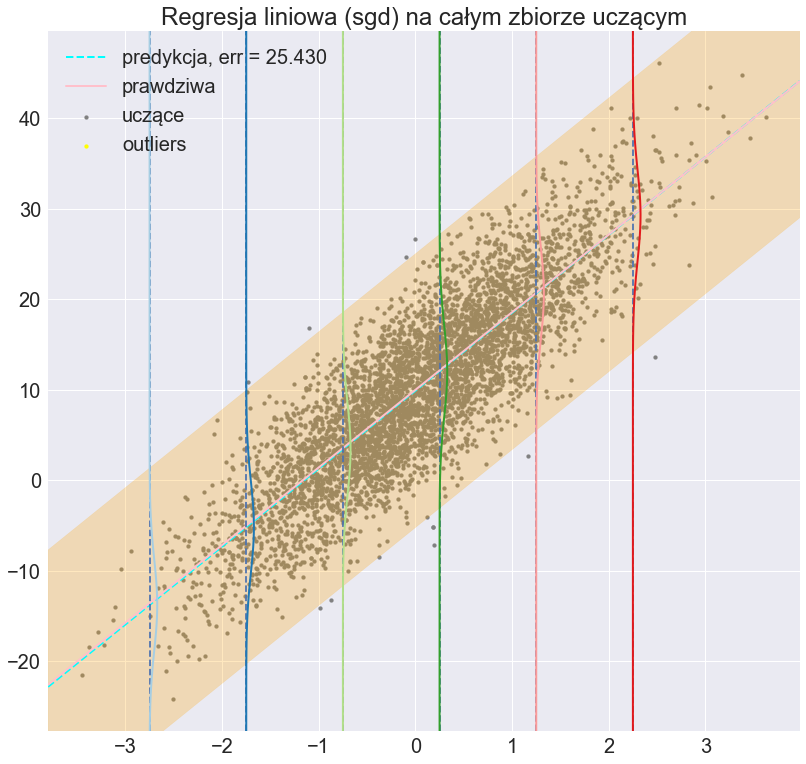

In [51]:
mle_regression(clf='sgd', max_iter=10000)

### Wartości odstające (outliers)
1. __reguła trzech sigm__ dla danych losowanych z rozkładu normalnego
  * 68.27\% obserwacji pochodzi z przedziału $\mu\pm1\sigma$  
  * 95.45\% obserwacji pochodzi z przedziału $\mu\pm2\sigma$  
  * 99.73\% obserwacji pochodzi z przedziału $\mu\pm3\sigma$
2. __wartości odstające__ (__outliers__) to wartości różniące się od średniej o więcej niż $4\sigma$

## Cechy MLE
1. __spójność__ estymatory MLE są zbieżne do _prawdziwej_ wartości wraz ze wzrostem liczby przykładów
2. __normalność__ rozkład parametrów jest zbieżny do normalnego wraz z liczbą danych
3. __minimalna wariancja__ osiągają asymptotycznie minimalną możliwą wariancję

## Maximum a posteriori MAP
1. __rozkład parametrów__ nie wszystkie wartości parametrów są poprawne
  * przybliżamy linie na drodze na widoku z kamery
    * przybliżanie wielomianem trzeciego stopnia $ax^3+bx^2+cx+d$
    * droga jest w miarę równoległa do osi pojazdu
      * niech $c\sim\mathcal{N}(0, \sigma_c)\hskip1em \text{dla}\hskip1em\sigma_c=0.5$
    * na drodze nie ma zbyt gwałtownych zakrętów
      * niech $a\sim\mathcal{N}(0, \sigma_a)\hskip1em \text{dla}\hskip1em\sigma_a=0.5$
  * ograniczenie możliwych klas funkcji (_regularyzacja_)
    * model liniowy
    * ograniczenie wartości parametrów
2. __rozkład__ np. dla interpolacji wielomianowej
$$\begin{align}
p(\theta\mid \sigma_\theta)&=\mathcal{N}(\theta\mid0,\sigma_{\theta})\\
&=\frac{1}{2\pi\sigma_\theta}^{\frac{D+1}{2}}\exp\left(-\frac{1}{2\sigma_\theta}\theta^T\theta\right)
\end{align}$$
  * $D+1$ liczba parametrów wielomianu
  * $\sigma_\theta$ wariancja parametrów
  
3. __reguła Bayesa__ $$p(\theta\mid X,Y,\sigma,\sigma_\theta)\propto p(Y\mid X,\theta,\sigma)p(\theta\mid\sigma_\theta)$$
  * __likelihood__ $$p(Y\mid X,\theta,\sigma)$$ problemu
  * __prior__ $$p(\theta\mid\sigma_\theta)$$ parametrów
  
4. __maximum a posteriori MAP__ maksymalizacja iloczynu likelihood i prior
  $$\theta^*=\underset{\theta}{\arg\max}p(\theta\mid D)$$
  * __stałe__ $p(\theta)=const$ daje MAP _równoważny_ maximum likelihood
  
5. __maximum posterior__
$$\begin{align}
\ln\,L&=\ln\,L_{problem}+\ln\,L_{parametry}\\
&\simeq\frac{\beta}{2\sigma^2}\sum_i(y_i-\widehat{y}(x_i;\theta))^2+\frac{\alpha}{2\sigma_{\theta}^2}\theta^T\theta\\
&\propto\frac{1}{2\sigma^2}\sum_i(y_i-\widehat{y}(x_i;\theta))^2+\frac{\lambda}{2\sigma_{\theta}^2}\theta^T\theta
\end{align}$$
dla $\lambda=\alpha/\beta$
  * __regularyzacja__ $$\frac{\alpha}{2\sigma_{\theta}^2}\theta^T\theta$$
    * większe wartości ograniczają możliwe rozwiązania
    

In [13]:
max_iter = 100
regr = SGDRegressor(max_iter=max_iter)
regr.fit(X, y)
print("Cały zbiór uczący")
print("\ttrue/computed coefficients: {:.3f}/{:.3f}, bias = {:.3f}".format(float(true_coef), 
                                            float(regr.coef_), bias))
predicted = regr.predict(X)
var = (1 / (10 * n_samples)) * np.sum((predicted - y) ** 2)

Cały zbiór uczący
	true/computed coefficients: 74.698/74.555, bias = 10.000


In [15]:
print("\tresidual error = {:.3f}".format(np.mean((predicted - y) ** 2)))
print("\tscore, = {:.3f}, var={}".format(regr.score(X, y), var))
ax.scatter(X, y, color='grey', s=dotsize, label='uczące')
ax.plot(X, predicted, color='blue', linewidth=1, label='predykcja')
ax.set_title('Cały zbiór uczący')

	residual error = 94.260
	score, = 0.985, var=9.426039417970143
